Topic 2: Pytorch Autograd
================

If you flag a torch Tensor with the attribute `x.requires_grad=True`, then pytorch will automatically keep track the computational history of all tensors that are derived from `x`.  This allows pytorch to figure out derivatives of any scalar result with regard to changes in the components of x.

<img src="autograd-graph.png" style="max-width:100%">

The function `torch.autograd.grad(output_scalar, [list of input_tensors])` computes `d(output_scalar)/d(input_tensor)` for each input tensor component in the list.  For it to work, the input tensors and output must be part of the same `requires_grad=True` compuation.

In the example here, `x` is explicitly marked `requires_grad=True`, so `y.sum()`, which is derived from `x`, automatically comes along with the computation history, and can be differentiated.

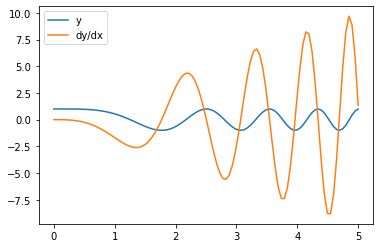

In [37]:
import torch
from matplotlib import pyplot as plt

x = torch.linspace(0, 5, 100,
          requires_grad=True)
y = (x**2).cos()
s = y.sum()
[dydx] = torch.autograd.grad(s, [x])

plt.plot(x.detach(), y.detach(), label='y')
plt.plot(x.detach(), dydx, label='dy/dx')
plt.legend()
plt.show()

(Note that in the example above, because the components of the vector space are independent of each other, we happen to have `dy[j] / dx[i] == 0` when `j != i`, so that `d(y.sum())/dx[i] = dy[i]/dx[i]`.  That means computing a single gradient vector of the sum `s` is equiavlent to computing elementwise derivatives `dy/dx`.)

**Detaching tensors from the computation history.** Every tensor that depends on `x` will be `requires_grad=True` and connected to the complete computation history. But if you were to convert a tensor to a regular python number, pytorch would not be able to see the calculations and would not be able to compute gradients on it.

To avoid programming mistakes where some computation invisibly goes through a non-pytorch number that cannot be tracked, pytorch disables requires-grad tensors from being converted to untrackable numbers.  You need to explicitly call `x.detach()` or `y.detach()` first, to explicitly say that you want an untracked reference, before plotting the data or using it as non-pytorch numbers.

### Exercise

Plot the polynomial y=x<sup>3</sup>-6x<sup>2</sup>+8x and its derivative, instead of cos(x<sup>2</sup>).

In [69]:
# TODO: set y to the given polynomial of x
y = 'TODO'

# TODO: use autograd to compute the derivative

# TODO: plot the results.


Backprop and In-place gradients
-------------------------------

In a typical neural network we will not just be getting gradients with regard to one input like `x` above, but with regard to a list of dozens or hundreds of tensor parameters that have all been marked with `requires_grad=True`.  It can be inconvenient to keep track of which gradient outputs go with which original tensor input.  But since the gradients have exactly the same shape as the inputs, it is natural to store computed gradients in-place on the tensors themselves.

**Using `backward()` to add `.grad` attributes.** To simplify this common operation, pytorch provides the `y.backward()` method, which computes the gradients of y with respect to every tracked dependency, and stores the results in the field `x.grad` for every original input vector `x` that was marked as `requires_grad=True`.

tensor([-0.0000e+00, -2.5765e-04, -2.0612e-03, -6.9560e-03, -1.6485e-02,
        -3.2185e-02, -5.5575e-02, -8.8145e-02, -1.3133e-01, -1.8650e-01,
        -2.5487e-01, -3.3752e-01, -4.3528e-01, -5.4869e-01, -6.7791e-01,
        -8.2262e-01, -9.8193e-01, -1.1543e+00, -1.3373e+00, -1.5279e+00,
        -1.7218e+00, -1.9138e+00, -2.0978e+00, -2.2665e+00, -2.4118e+00,
        -2.5246e+00, -2.5954e+00, -2.6144e+00, -2.5720e+00, -2.4592e+00,
        -2.2684e+00, -1.9940e+00, -1.6330e+00, -1.1861e+00, -6.5843e-01,
        -5.9786e-02,  5.9438e-01,  1.2829e+00,  1.9791e+00,  2.6508e+00,
         3.2620e+00,  3.7737e+00,  4.1467e+00,  4.3434e+00,  4.3315e+00,
         4.0872e+00,  3.5983e+00,  2.8676e+00,  1.9159e+00,  7.8273e-01,
        -4.7262e-01, -1.7729e+00, -3.0265e+00, -4.1327e+00, -4.9894e+00,
        -5.5028e+00, -5.5970e+00, -5.2252e+00, -4.3782e+00, -3.0925e+00,
        -1.4526e+00,  4.1007e-01,  2.3249e+00,  4.0956e+00,  5.5192e+00,
         6.4094e+00,  6.6222e+00,  6.0798e+00,  4.7

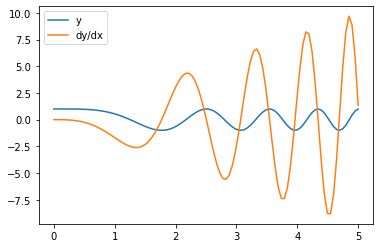

In [70]:
x = torch.linspace(0, 5, 100, requires_grad=True)
y = (x**2).cos()
y.sum().backward()   # populates the grad attribute below.
print(x.grad)

plt.plot(x.detach(), y.detach(), label='y')
plt.plot(x.detach(), x.grad, label='dy/dx')
plt.legend()
plt.show()

### Exercise

1. Introduce a new vector x<sub>2</sub> which also ranges from zero to five (same as x, but not cloned from x).
2. Plot the polynomial y=x<sub>2</sub><sup>3</sup>-6x<sup>2</sup>+8x
3. Plot dy/dx and dy/dx<sub>2</sub>.

Which x contributes most to the gradient at zero?  At five?

In [72]:
# TODO: define x2 just like x, but not cloned from x
x2 = 'TODO'

# TODO: Plot the given polynomial which depends on both x and x2

# TODO: Plot both dy/dx and dy/dx2.  Explain what you get.

Accumulating and Zeroing grad
-----------------------------

**Gradient accumulation.** If you find that your data batches are too large to get gradients of the
whole thing, then it is usually possible to split the batches into smaller pieces and add the
gradients. Because gradient accumulation is a common pattern, if you call `.backward()` when parameters
`x.grad` already exists, it is not an error.  The new gradient will be *added* to the old one.

**zero_grad().** That means that you need to set any previous value of `x.grad` to zero before
running `backward()`, or else the new gradient will be added to the old one.  Optimizers have a
utility `optim.zero_grad()` to do this to all the optimized parameters at once.

Saving memory on inference
--------------------------

**Avoid autograd when you don't need it.** Normally, all the parameters of a neural network are set to `requires_grad=True` by default, so they are ready to be trained.  But that means that whenever you run a network, you will get output which is also requires-grad, and it will be attached to a long computation history that consumes a lot of precious GPU memory.

To avoid all this expense when you have no intention of training the network, you could go through all the network parameters to set `requires_grad=False`.

Another way to avoid the computation history is to enclose the entire computation within a `with torch.no_grad():` block.  This will suppress all the autograd mechanics (which means, of course, `.backward()` will not function).

Note that this is different from the role of `net.eval()` which puts puts the network in inference mode computationally (batchnorm, dropout, and other operations behave differently in training and inference); `net.eval()` does not have any effect on `requires_grad`.

More tricks
-----------

**Gradients over intermediate values.** Normally gradients with respect to intermediate values are not stored in `.grad` - just original input variables - but you can ask for intermediate gradients to be stored using `v.retain_grad()`.

**Second derivatives.** If you want higher-order derivatives, then you want pytorch to build the computation graph when it is computing the gradient itself, so this graph can be differentiated again.  To do this, use the `create_graph=True` option on the `grad` or `backward` methods.

**Gradients of more than one objective.** Usually you only need to call `y.backward()` once per computation tree, and pytorch will not let you call it again. To save memory, pytorch will have deallocated the computation graph after you have computed a single gradient.  But if you need more than one gradient (e.g., if you have different objectives that you want to apply to different subsets of parameters, as with happens with GANs sometimes), you can use `retain_graph=True`.


### Exercise

1. Plot the polynomial y=x<sup>3</sup>-6x<sup>2</sup>+8x, just as in the first exercise.
2. Use `y.sum().backward(create_graph=True)` to compute the gradient, and plot dy/dx.  Why is `x.grad.detach()` needed now?
3. Now set `dy = x.grad.clone()` and then `x.grad.zero_()`, before using `dy.sum().backward()` to compute a 2nd gradient.  Plot d<sup>2</sup>y/dx.

In [74]:
# TODO: define the polynomial just like the first exercise
y = 'TODO'

# TODO: Use `backward(create_graph=True)` to compute dy/dx.  Plot it.

# TODO: Use `backward()` a second time to compute the second derivative.  Plot it.

### [On to topic 3: Optimizers &rightarrow;](3-Pytorch-Optimizers.ipynb)